In [1]:
!pip install python_speech_features
!pip install python-dotenv 


In [2]:
!pip install keras --upgrade

Requirement already up-to-date: keras in c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages (2.3.1)


In [3]:
# !pip list librosa

In [22]:
import time
import numpy as np
import pandas as pd
from python_speech_features import mfcc
import os
from keras import layers
from keras import models
import keras
from keras import optimizers
from keras import regularizers
from keras import activations
from keras import backend as K
from keras.utils.data_utils import get_file

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import sys
sys.path.append('/content/drive/My Drive/cs577- Deep learning/deepMusic/')
from src.helper import utils
from sklearn import preprocessing
import librosa
import matplotlib.pyplot as plt
import librosa.display
from sklearn.utils.class_weight import compute_class_weight
from math import floor
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
import keras.backend.tensorflow_backend as tfback
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus



tf.__version__ is 2.1.0
tf.keras.__version__ is: 2.2.4-tf


In [8]:
root_folder = "D:\Code\Desktop\IIT\Courses\Spring 2020\Deep Learning\FInal Project\github_project\music_analysis_fp\\"
subset_config = {
    "audio_dir": "fma_small",
    "subset": "small"
}

gen_params = {
    'dim': (96, 1366),
    # 'dim': (96, 469),
    'batch_size': 10,
    'n_classes': 4,
    'n_channels': 1,
    'shuffle': True
}


config = {
    'audio_dir': root_folder + "data/" + subset_config['audio_dir'],
    'tracks': root_folder + 'data/fma_metadata/cleaned_' + subset_config['subset'] + '.csv',
    'generator_params': gen_params,
    'audio_loader': utils.FfmpegLoader()
}


In [13]:
# Load npy files
x_train = np.load(root_folder + "data/npy_files/" + subset_config['subset'] + "/x_train.npy")
y_train = np.load(root_folder + "data/npy_files/" + subset_config['subset'] + "/y_train.npy")

x_val = (np.load(root_folder + "data/npy_files/" + subset_config['subset'] + "/x_val.npy"))
y_val = (np.load(root_folder + "data/npy_files/" + subset_config['subset'] + "/y_val.npy"))

x_test = (np.load(root_folder + "data/npy_files/" + subset_config['subset'] + "/x_test.npy"))
y_test = (np.load(root_folder + "data/npy_files/" + subset_config['subset'] + "/y_test.npy"))

x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1],x_train.shape[2],x_train.shape[3],x_train.shape[4]))
x_val = x_val.reshape((x_val.shape[0]*x_val.shape[1],x_val.shape[2],x_val.shape[3],x_val.shape[4]))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1],x_test.shape[2],x_test.shape[3],x_test.shape[4]))

y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1],y_train.shape[2]))
y_val = y_val.reshape((y_val.shape[0]*y_val.shape[1],y_val.shape[2]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1],y_test.shape[2]))

print(f'y_train -> {y_train.shape}')
print(f'x_train -> {x_train.shape}')
print(f'x_val -> {len(x_val)}')
print(f'x_test -> {len(x_test)}')

y_train -> (3190, 4)
x_train -> (3190, 1, 96, 469)
x_val -> 400
x_test -> 400


In [11]:
def plot_mel_spect(spect):
    # spect = spect.flatten()
    # print(spect)
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(spect.T, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Test Melspectogram')
    plt.show()

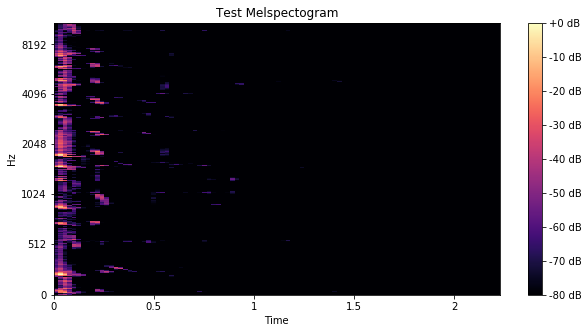

In [14]:
plot_mel_spect(x_train[0][0])

In [15]:
def plot_epocs_graph(history_dict,i):
    loss_vals = history_dict['loss']
    val_loss_vals = history_dict['val_loss']
    epochs = range(1, len(history_dict['acc']) + 1)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_vals, 'g', label='Training Loss')
    plt.plot(epochs, val_loss_vals, 'b', label='Validation Loss')
    plt.title("Training and validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc_vals = history_dict['acc']
    val_acc_vals = history_dict['val_acc']
    plt.plot(epochs, acc_vals, 'g', label='Training accuracy')
    plt.plot(epochs, val_acc_vals, 'b', label='Validation accuracy')
    plt.title("Training and validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(root_folder + f'graphs/log{i}.png')
    plt.show()
    return

In [16]:
'''
USE THIS FOR MEDIUM DATASET
'''

def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False


def MusicTaggerCRNN(weights='msd', input_tensor=None):
    '''Instantiate the MusicTaggerCRNN architecture,
    optionally loading weights pre-trained
    on Million Song Dataset. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    For preparing mel-spectrogram input, see
    `audio_conv_utils.py` in [applications](https://github.com/fchollet/keras/tree/master/keras/applications).
    You will need to install [Librosa](http://librosa.github.io/librosa/)
    to use it.

    # Arguments
        weights: one of `None` (random initialization)
            or "msd" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
    # Returns
        A Keras model instance.
    '''
    K.clear_session()
    K.set_image_data_format('channels_first')
    if weights not in {'msd', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `msd` '
                         '(pre-training on Million Song Dataset).')

    # Determine proper input shape
    if K.image_data_format() == 'channels_first':
        input_shape = (1, 96, 1366)
    else:
        input_shape = (96, 1366, 1)

    if input_tensor is None:
        melgram_input = layers.Input(shape=input_shape)
    else:
        melgram_input = layers.Input(shape=input_tensor)

    # Determine input axis
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        freq_axis = 2
        time_axis = 3
    else:
        channel_axis = 3
        freq_axis = 1
        time_axis = 2

    # Input block
    # x = layers.ZeroPadding2D(padding=(0, 37))(melgram_input)
    # x = layers.BatchNormalization(axis=time_axis, name='bn_0_freq')(x)

    # Conv block 1
    x = layers.Convolution2D(16,(2, 2), border_mode='same', name='conv1',activation= 'selu', trainable=True,kernel_initializer='lecun_normal')(melgram_input)
    x = layers.BatchNormalization(axis=channel_axis, mode=0, name='bn1', trainable=True)(x)
    # x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool1')(x)
    x = layers.AlphaDropout(0.1, name='dropout1', trainable=True)(x)

    # Conv block 2
    x = layers.Convolution2D(32,(2, 2), border_mode='same', name='conv2',activation= 'selu', trainable=True,kernel_initializer='lecun_normal')(x)
    x = layers.BatchNormalization(axis=channel_axis, mode=0, name='bn2', trainable=True)(x)
    # x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2')(x)
    x = layers.AlphaDropout(0.1, name='dropout2', trainable=True)(x)

    # # Conv block 3
    x = layers.Convolution2D(32,(3, 3), border_mode='same', name='conv3',activation= 'selu', trainable=True, kernel_initializer='lecun_normal')(x)
    x = layers.BatchNormalization(axis=channel_axis, mode=0, name='bn3', trainable=True)(x)
    # x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool3')(x)
    x = layers.AlphaDropout(0.1, name='dropout3', trainable=True)(x)


    # reshaping
    if K.image_data_format() == 'channels_first':
        x = layers.Permute((3, 1, 2))(x)
    # print(f'permute size -> {x.shape}')
    shape = x.get_shape().as_list()
    x = layers.Reshape((shape[1]*shape[-1],shape[2]))(x)

    # GRU block 1, 2, output
    x = layers.GRU(8, return_sequences=True, name='gru1')(x)
    x = layers.GRU(8, return_sequences=False, name='gru2')(x)
    x = layers.AlphaDropout(0.3, name='final_drop')(x)

    ## LSTM Layer
    # layer = LSTM(96,return_sequences=False)(x)
    # x = Dropout(0.4)(layer)
    # print(f'lstm layer -> {layer.shape}')

    if weights is None:
        x = layers.Dense(128, activation='relu', name='hidden1')(x)
        x = layers.Dense(4, activation='softmax', name='output')(x)
        print(f'x.shape -> {x.shape}')

        model = models.Model(melgram_input, x)
        # model.summary()
        return model
        # return x
    else:
        # Load input
        x = layers.Dense(10, activation='sigmoid', name='output')(x)
        if K.image_data_format() == 'channels_last':
            raise RuntimeError("Please set image_dim_ordering == 'th'."
                               "You can set it at ~/.keras/keras.json")
        # Create model
        initial_model = models.Model(melgram_input, x)
        initial_model.load_weights('/content/crnn_net_gru_adam_ours_epoch_40.h5')

        # Eliminate last layer
        pop_layer(initial_model)
        pop_layer(initial_model)
        # Add new Dense layer
        last = initial_model.get_layer('gru2')
        preds = layers.Dense(4, activation='sigmoid', name='preds')(last.output)
        model = models.Model(initial_model.input, preds)

        # TO extend this model use this,
        # model = Model(initial_model.input, initial_model.get_layer('dropout2').output)

        return model

In [20]:
network_config = {
#     'input_shape' : (1,96,1366),
    'input_shape' : (1,96,469),
    'loss' : 'categorical_crossentropy',
    'optimizer' : optimizers.Adam(learning_rate=0.0001),
    'metrics' : ['acc'],
    'epochs' : 2,
    'batch_size':128,

}

In [23]:
model = MusicTaggerCRNN(weights=None, input_tensor=network_config['input_shape'])

model.compile(loss=network_config['loss'],
              optimizer=network_config['optimizer'],
              metrics=network_config['metrics'])
model.summary()

# Training from memory
train_val_history = model.fit(x_train,y_train,
                              batch_size=network_config['batch_size'],
                              epochs=network_config['epochs'],
                              validation_data = (x_val, y_val))
history_dict = train_val_history.history
plot_epocs_graph(history_dict=history_dict,i=17)
# model.save(root_folder + 'models/crnn_20.h5')

print(f'Testing...')
test_op = model.evaluate(x_test,y_test)
print('Testing accuracy -> ',test_op)



c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (2, 2), name="conv1", activation="selu", trainable=True, kernel_initializer="lecun_normal", padding="same")`
c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=1, name="bn1", trainable=True)`
c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), name="conv2", activation="selu", trainable=True, kernel_initializer="lecun_normal", padding="same")`
c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:87: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=1, name="bn2", trainable

x.shape -> (None, 4)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 96, 469)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 96, 469)       80        
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 96, 469)       64        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 32, 156)       0         
_________________________________________________________________
dropout1 (AlphaDropout)      (None, 16, 32, 156)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 156)       2080      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv1/convolution (defined at c:\users\bisar\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_14710]

Function call stack:
keras_scratch_graph


In [ ]:
from keras.models import load_model
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

weights_path = root_folder + 'models/crnn_20.h5'
model = load_model(weights_path)
x_test = (np.load(root_folder + "npy_files_new/medium/medium/x_test.npy"))
y_test = (np.load(root_folder + "npy_files_new/medium/medium/y_test.npy"))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1],y_test.shape[2]))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1],x_test.shape[2],x_test.shape[3],x_test.shape[4]))

#Confution Matrix and Classification Report
Y_pred = model.predict(x_test, batch_size = 128)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred.shape)
y_test_clasess = np.argmax(y_test, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_clasess, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ['Electronic', 'Folk', 'Rock','Hip-Hop']],
                  columns = [i for i in ['Electronic', 'Folk', 'Rock','Hip-Hop']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
print('Classification Report')
target_names = ['Electronic', 'Folk', 'Rock','Hip-Hop']
print(classification_report(y_test_clasess, y_pred, target_names=target_names))

In [ ]:
'''
USE IT FOR FMA SMALL DATASET

'''
# def pop_layer(model):
#     if not model.outputs:
#         raise Exception('Sequential model cannot be popped: model is empty.')

#     model.layers.pop()
#     if not model.layers:
#         model.outputs = []
#         model.inbound_nodes = []
#         model.outbound_nodes = []
#     else:
#         model.layers[-1].outbound_nodes = []
#         model.outputs = [model.layers[-1].output]
#     model.built = False


# def MusicTaggerCRNN(weights='msd', input_tensor=None):
#     '''Instantiate the MusicTaggerCRNN architecture,
#     optionally loading weights pre-trained
#     on Million Song Dataset. Note that when using TensorFlow,
#     for best performance you should set
#     `image_dim_ordering="tf"` in your Keras config
#     at ~/.keras/keras.json.

#     The model and the weights are compatible with both
#     TensorFlow and Theano. The dimension ordering
#     convention used by the model is the one
#     specified in your Keras config file.

#     For preparing mel-spectrogram input, see
#     `audio_conv_utils.py` in [applications](https://github.com/fchollet/keras/tree/master/keras/applications).
#     You will need to install [Librosa](http://librosa.github.io/librosa/)
#     to use it.

#     # Arguments
#         weights: one of `None` (random initialization)
#             or "msd" (pre-training on ImageNet).
#         input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
#             to use as image input for the model.
#     # Returns
#         A Keras model instance.
#     '''

#     K.set_image_data_format('channels_first')
#     if weights not in {'msd', None}:
#         raise ValueError('The `weights` argument should be either '
#                          '`None` (random initialization) or `msd` '
#                          '(pre-training on Million Song Dataset).')

#     # Determine proper input shape
#     if K.image_data_format() == 'channels_first':
#         input_shape = (1, 96, 1366)
#     else:
#         input_shape = (96, 1366, 1)

#     if input_tensor is None:
#         melgram_input = layers.Input(shape=input_shape)
#     else:
#         melgram_input = layers.Input(shape=input_tensor)

#     # Determine input axis
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#         freq_axis = 2
#         time_axis = 3
#     else:
#         channel_axis = 3
#         freq_axis = 1
#         time_axis = 2

#     # Input block
#     # x = layers.ZeroPadding2D(padding=(0, 37))(melgram_input)
#     # x = layers.BatchNormalization(axis=time_axis, name='bn_0_freq')(x)

#     # Conv block 1
#     x = layers.Convolution2D(16,(2, 2), border_mode='same', name='conv1',activation= 'selu', trainable=True,kernel_initializer='lecun_normal')(melgram_input)
#     x = layers.BatchNormalization(axis=channel_axis, mode=0, name='bn1', trainable=True)(x)
#     # x = layers.ReLU()(x)
#     x = layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool1')(x)
#     x = layers.AlphaDropout(0.1, name='dropout1', trainable=True)(x)

#     # Conv block 2
#     x = layers.Convolution2D(32,(2, 2), border_mode='same', name='conv2',activation= 'selu', trainable=True,kernel_initializer='lecun_normal')(x)
#     x = layers.BatchNormalization(axis=channel_axis, mode=0, name='bn2', trainable=True)(x)
#     # x = layers.ReLU()(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(x)
#     x = layers.AlphaDropout(0.1, name='dropout2', trainable=True)(x)

#     # # Conv block 3
#     x = layers.Convolution2D(32,(3, 3), border_mode='same', name='conv3',activation= 'selu', trainable=True, kernel_initializer='lecun_normal')(x)
#     x = layers.BatchNormalization(axis=channel_axis, mode=0, name='bn3', trainable=True)(x)
#     # x = layers.ReLU()(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3')(x)
#     x = layers.AlphaDropout(0.1, name='dropout3', trainable=True)(x)
    
#     # model = models.Model(melgram_input, x)
#     # model.summary()

#     # # Conv block 4
#     # x = layers.Convolution2D(16,( 4, 4), border_mode='same', name='conv4',activation= 'selu', trainable=True, kernel_initializer='lecun_normal')(x)
#     # x = layers.BatchNormalization(axis=channel_axis, mode=0, name='bn4', trainable=True)(x)
#     # # x = layers.ELU()(x)
#     # x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool4')(x)
#     # x = layers.Dropout(0.1, name='dropout4', trainable=True)(x)

#     # reshaping
#     if K.image_data_format() == 'channels_first':
#         x = layers.Permute((3, 1, 2))(x)
#     # print(f'permute size -> {x.shape}')
#     shape = x.get_shape().as_list()
#     x = layers.Reshape((shape[1]*shape[-1],shape[2]))(x)

#     # GRU block 1, 2, output
#     x = layers.GRU(8, return_sequences=True, name='gru1')(x)
#     x = layers.GRU(8, return_sequences=False, name='gru2')(x)
#     x = layers.AlphaDropout(0.3, name='final_drop')(x)

#     ## LSTM Layer
#     # layer = LSTM(96,return_sequences=False)(x)
#     # x = Dropout(0.4)(layer)
#     # print(f'lstm layer -> {layer.shape}')

#     if weights is None:
#         # x = layers.Flatten()(x)
#         x = layers.Dense(128, activation='relu', name='hidden1')(x)
#         x = layers.Dense(4, activation='softmax', name='output')(x)
#         print(f'x.shape -> {x.shape}')

#         model = models.Model(melgram_input, x)
#         # model.summary()
#         return model
#         # return x
#     else:
#         # Load input
#         x = layers.Dense(10, activation='sigmoid', name='output')(x)
#         if K.image_data_format() == 'channels_last':
#             raise RuntimeError("Please set image_dim_ordering == 'th'."
#                                "You can set it at ~/.keras/keras.json")
#         # Create model
#         initial_model = models.Model(melgram_input, x)
#         initial_model.load_weights('/content/crnn_net_gru_adam_ours_epoch_40.h5')

#         # Eliminate last layer
#         pop_layer(initial_model)
#         pop_layer(initial_model)
#         # Add new Dense layer
#         last = initial_model.get_layer('gru2')
#         preds = layers.Dense(4, activation='sigmoid', name='preds')(last.output)
#         model = models.Model(initial_model.input, preds)

#         # TO extend this model use this,
#         # model = Model(initial_model.input, initial_model.get_layer('dropout2').output)

#         return model